In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

# Chargement et preprocessing des données

In [2]:
df = pd.read_csv('winequality-red.csv', sep=';')
print(df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
pd.value_counts(df.quality)

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [4]:
X = df.iloc[:, :11]
y = df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1506)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Baseline naives
## Valeur de qualité aléatoire
La qualité du vin est choisi aléatoirement entre la moins bonne et la meilleure note du jeu d'entrainement.

In [5]:
n = len(X_test)
y_pred_aleatoire = y_train.min() + np.random.rand(n) * (y_train.max() - y_train.min())

## Valeur moyenne

In [6]:
y_pred_moyenne = y_train.mean() * np.ones(n)

## Valeur médiane

In [7]:
y_pred_mediane = y_train.median() * np.ones(n)

# Métriques de performance
On utilise 2 métriques pour comparer les performances des régresseurs: la MSE et le R².

In [8]:
MSE_dict = {'aleatoire': mean_squared_error(y_test, y_pred_aleatoire),
       'moyenne': mean_squared_error(y_test, y_pred_moyenne),
       'mediane': mean_squared_error(y_test, y_pred_mediane)}
R2_dict = {'aleatoire': r2_score(y_test, y_pred_aleatoire),
       'moyenne': r2_score(y_test, y_pred_moyenne),
       'mediane': r2_score(y_test, y_pred_mediane)}

print(MSE_dict)
print(R2_dict)

{'aleatoire': 2.6781035079548605, 'moyenne': 0.6221230836130497, 'mediane': 0.7625}
{'aleatoire': -3.306498103243997, 'moyenne': -0.0003989284229946044, 'mediane': -0.22613065326633164}


Intriguant: on a un R² négatif pour les 3 régresseurs, d'après la doc de scikit-learn ça serait possible d'avoir un R² négatif.
# Implémentation de notre propre régresseur à l'aide de KNeighborsRegressor
On peut réutiliser ici une partie du code de l'exercice du premier chapitre du cours.

In [9]:
def my_grid_search(reg, X, y, param_n_neighbors, cv=5):
    MSE = {}
    R2 = {}
    k_fold_MSE = {}
    k_fold_R2 = {}
    
    n = len(X)
    idx_sep = (n/cv * np.arange(cv + 1)).astype('int64')
    
    for neighbors in param_n_neighbors:
        reg.set_params(n_neighbors=neighbors)
        k_fold_MSE[neighbors] = []
        k_fold_R2[neighbors] = []
        for k in np.arange(cv):
            mask = (np.arange(n) >= idx_sep[k]) & (np.arange(n) < idx_sep[k + 1])
            X_train_k, y_train_k = X[~mask], y[~mask]
            X_test_k, y_test_k = X[mask], y[mask]
            
            reg.fit(X_train_k, y_train_k)
            y_pred = reg.predict(X_test_k)
            k_fold_MSE[neighbors].append(mean_squared_error(y_test_k, y_pred))
            k_fold_R2[neighbors].append(r2_score(y_test_k, y_pred))
            
        MSE[neighbors] = np.mean(k_fold_MSE[neighbors])
        R2[neighbors] = np.mean(k_fold_R2[neighbors])
    return(param_n_neighbors, MSE, R2, k_fold_MSE, k_fold_R2) 

In [10]:
param = [2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 22, 27, 33, 40, 50, 75, 100]
(n_neighbors, mse, r2, _ , _) = my_grid_search(KNeighborsRegressor(), X_train_std, y_train, param, cv=5)

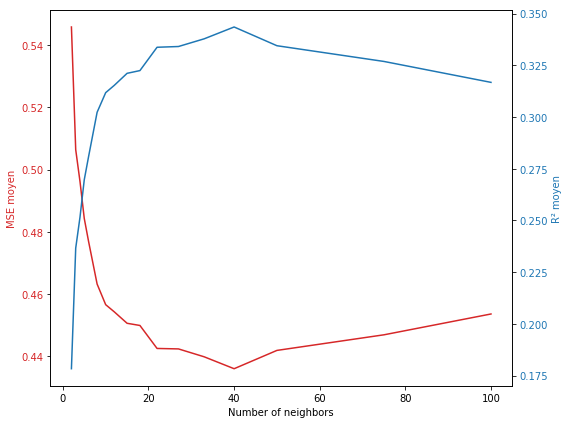

In [11]:
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('Number of neighbors')
ax1.set_ylabel('MSE moyen', color=color)
ax1.plot(n_neighbors, mse.values(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R² moyen', color=color)  # we already handled the x-label with ax1
ax2.plot(n_neighbors, r2.values(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Le nombre de voisins optimal est 40. Il présente une MSE la plus faible. On remarque que la MSE est inversement proportionnel au R².

In [12]:
knn = KNeighborsRegressor(n_neighbors=40).fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
MSE_dict['my_grid_40'] = mean_squared_error(y_test, y_pred)
R2_dict['my_grid_40'] = r2_score(y_test, y_pred)
print('R² score on test set: {}'.format(R2_dict['my_grid_40']))

R² score on test set: 0.33111390284757114


# Equivalent en utilisant la fonction GridSearchCV de scikit-learn

In [13]:
neigh_dict = {'n_neighbors': [2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 22, 27, 33, 40, 50, 75, 100]}
score = 'r2'
grid_cv = GridSearchCV(KNeighborsRegressor(),
                    param_grid=neigh_dict,
                    scoring=score,
                    cv=5)

grid_cv.fit(X_train_std, y_train)
print(grid_cv.best_params_)
y_pred = grid_cv.predict(X_test_std)
MSE_dict['sklearn_best_grid'] = mean_squared_error(y_test, y_pred)
R2_dict['sklearn_best_grid'] = r2_score(y_test, y_pred)
print('R² score on test set: {}'.format(R2_dict['sklearn_best_grid']))

{'n_neighbors': 40}
R² score on test set: 0.33111390284757114


On obtient le même R² avec la fonction implémentée et celle de sklearn.  
On utilisera donc comme modèle finale, celui avec 40 voisins qui dépasse nettement les performances des régresseurs naives.

In [14]:
print('MEAN SQUARED ERROR:', MSE_dict)
print('R SQUARED:', R2_dict)

MEAN SQUARED ERROR: {'aleatoire': 2.6781035079548605, 'moyenne': 0.6221230836130497, 'mediane': 0.7625, 'my_grid_40': 0.4159635416666667, 'sklearn_best_grid': 0.4159635416666667}
R SQUARED: {'aleatoire': -3.306498103243997, 'moyenne': -0.0003989284229946044, 'mediane': -0.22613065326633164, 'my_grid_40': 0.33111390284757114, 'sklearn_best_grid': 0.33111390284757114}


[]

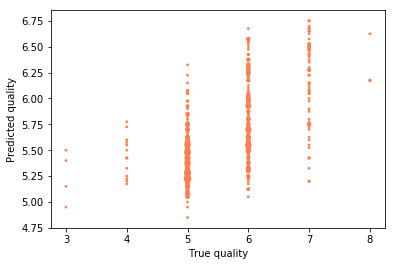

In [15]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter([k[0] for k in keys], # vraie valeur (abscisse)
            [k[1] for k in keys], # valeur predite (ordonnee)
            s=[sizes[k] * 3 for k in keys], # taille du marqueur
            color='coral')
plt.xlabel('True quality')
plt.ylabel('Predicted quality')
plt.plot()